# Control comparison
## wC and noC and baseline as baseline 
### load models and scalers and matrices

In [166]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle 
import scipy
import time as tim

from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.slim import slim
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks
import joblib

from sklearn.preprocessing import StandardScaler, MinMaxScaler
torch.manual_seed(0)

In [167]:
with open('data/train_real.pkl', 'rb') as fp:
        train_sim = pickle.load(fp)

with open('data/test_real.pkl', 'rb') as fp:
        test_sim = pickle.load(fp)

In [168]:
scaler = joblib.load('data/scaler.pkl')
scalerU = joblib.load('data/scalerU.pkl')

In [169]:
A_wC = np.load('data/A_wC.npy')
B_wC = np.load('data/B_wC.npy')
C_wC = np.load('data/C_wC.npy')
D_wC = np.zeros((C_wC.shape[0], B_wC.shape[1]))

In [170]:
A_noC = np.load('data/A_noC.npy')
B_noC = np.load('data/B_noC.npy')

In [171]:
nx_koopman = 10# 
nx_koopman_baseline = 80
# n_hidden = 32
# n_layers = 2
layers = [60,60,60]
layers_baseline = [60,60,60]
ny = 1
nu = 1
nsteps = 80 

In [172]:
# wC

# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nx_koopman,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')
# instantiate input encoder net f_u

f_u = torch.nn.Linear(nu, nx_koopman, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

f_y_inv = torch.nn.Linear(nx_koopman, ny, bias=False)
# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

In [173]:
# noC

# instantiate output encoder neural net f_y
f_y_noC = blocks.MLP(
    ny,
    nx_koopman,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0_noC = Node(f_y_noC, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y_noC = Node(f_y_noC, ['Y'], ['x_latent'], name='encoder_Y')
# instantiate input encoder net f_u

f_u_noC = torch.nn.Linear(nu, nx_koopman, bias=False)
# initial condition encoder
encode_U_noC = Node(f_u_noC, ['U'], ['u_latent'], name='encoder_U')

# instantiate state decoder neural net f_y_inv
f_y_inv_noC = blocks.MLP(nx_koopman, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ELU,
                hsizes=layers)
#f_y_inv = torch.nn.Linear(nx_koopman, ny, bias=False)
# predicted trajectory decoder
decode_y_noC = Node(f_y_inv_noC, ['x'], ['yhat'], name='decoder_y')

In [174]:
# baseline

f_y_baseline = blocks.MLP(
    ny,
    nx_koopman_baseline,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers_baseline,
)
# initial condition encoder
encode_Y0_baseline = Node(f_y_baseline, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y_baseline = Node(f_y_baseline, ['Y'], ['x_latent'], name='encoder_Y')

f_u_baseline = torch.nn.Linear(nu, nx_koopman_baseline, bias=False)
# initial condition encoder
encode_U_baseline = Node(f_u_baseline, ['U'], ['u_latent'], name='encoder_U')
# instantiate state decoder neural net f_y_inv
f_y_inv_baseline = blocks.MLP(nx_koopman_baseline, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ELU,
                hsizes=layers_baseline)
# f_y_inv = torch.nn.Linear(nx_koopman, ny, bias=False)
# predicted trajectory decoder
decode_y_baseline = Node(f_y_inv_baseline, ['x'], ['yhat'], name='decoder_y')


In [175]:
K = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)
K_noC = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)
K_baseline = torch.nn.Linear(nx_koopman_baseline, nx_koopman_baseline, bias=False)

In [176]:
class Koopman_control(nn.Module):
    """
    Baseline class for Koopman control model
    Implements discrete-time dynamical system:
        x_k+1 = K x_k + u_k
    with variables:
        x_k - latent states
        u_k - latent control inputs
    """

    def __init__(self, K):
        super().__init__()
        self.K = K

    def forward(self, x, u):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nx])
        :return: (torch.Tensor, shape=[batchsize, nx])
        """
        x = self.K(x) + u
        return x

In [177]:
# symbolic Koopman model with control inputs
Koopman = Node(Koopman_control(K), ['x', 'u_latent'], ['x'], name='K')
Koopman_noC = Node(Koopman_control(K_noC), ['x', 'u_latent'], ['x'], name='K')
Koopman_baseline = Node(Koopman_control(K_baseline), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)
dynamics_model_noC = System([Koopman_noC], name='Koopman', nsteps=nsteps)
dynamics_model_baseline = System([Koopman_baseline], name='Koopman', nsteps=nsteps)

In [178]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

nodes_noC = [encode_Y0_noC, encode_Y_noC, encode_U_noC, dynamics_model_noC, decode_y_noC]

nodes_baseline = [encode_Y0_baseline, encode_Y_baseline, encode_U_baseline, dynamics_model_baseline, decode_y_baseline]

In [179]:
# variables
Y = variable("Y")  # observed
yhat = variable('yhat')  # predicted output
x_latent = variable('x_latent')  # encoded output trajectory in the latent space
u_latent = variable('u_latent')  # encoded input trajectory in the latent space
x = variable('x')  # Koopman latent space trajectory

xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10. * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reconstruction loss
reconstruction_loss = 20.*(yhat[:, 0, :] == Y[:, 0, :])^2
reconstruction_loss.name = "reconstruction_loss"


# latent trajectory tracking loss
x_loss = 1. * (x[:, 1:-1, :] == xu_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"


In [180]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss, reconstruction_loss]


# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

problem_noC = Problem(nodes_noC, loss)

problem_baseline = Problem(nodes_baseline, loss)

In [181]:
problem.load_state_dict(torch.load('data/modelC.pth'),strict=False)



<All keys matched successfully>

In [182]:
problem_noC.load_state_dict(torch.load('data/model_noC.pth'),strict=False)



<All keys matched successfully>

In [183]:
problem_baseline.load_state_dict(torch.load('data/model_baseline.pth'),strict=False)

<All keys matched successfully>

## Control

In [184]:
import sys
sys.path.append('../functions')

import numpy as np
from scipy.linalg import expm
import dense
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [185]:
def get_x(y):
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"][0].detach().numpy().reshape(1,-1).T

A_baseline = K_baseline.weight.detach().numpy()
B_baseline = f_u_baseline.weight.detach().numpy()

def get_y_baseline(x):
    y_ = problem_baseline.nodes[4]({"x": torch.from_numpy(x).float()})
    return y_["yhat"][0].detach().numpy().reshape(1,-1).T

def get_x_baseline(y):
    x = problem_baseline.nodes[0]({"Y0": torch.from_numpy(y.reshape(1,-1,1)).float()})
    return x["x"][0].detach().numpy().reshape(1,-1).T

def y_plus_baseline(x,u):
    x_plus = A_baseline@x + B_baseline@u
    y_plus = problem_baseline.nodes[4]({"x": torch.from_numpy(x_plus).float()})
    return y_plus["yhat"][0].detach().numpy().reshape(1,-1).T, x_plus

In [186]:
sim_length = 400
y_ = scaler.transform(np.array([[20]]))
x_basline = np.zeros((nx_koopman_baseline, sim_length+1))
x0_baseline = get_x_baseline(y_)
x_basline[:,0] = x0_baseline.flatten()
y = np.zeros((ny, sim_length+1))

for i in range(sim_length):
    y[:,i+1], x_basline[:,i+1] = y_plus_baseline(x_basline[:,i], np.array([-2])) #u[:, i]
scaler.inverse_transform([y[:,-1]])

array([[24.41881597]])

In [187]:
y[:,-1]

array([-2.6262207])

In [188]:
scaler.inverse_transform(np.array([[-1]]))

array([[38.40084585]])

In [189]:
noise_mean = 0
noise_std = 0.005
noise = np.random.normal(noise_mean, noise_std)

## NoC

In [190]:
def get_x_noC(y):
    x = problem_noC.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1,-1).T

def get_y_noC(x):
    y = problem_noC.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"][0].detach().numpy().reshape(1,-1).T

def get_vector_y_noC(x):
    y = problem_noC.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1,-1).T

In [191]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# Define the state transition function (Linear)
def f_cv(state, u):
    x = state.reshape(-1,1)
    x_new = A_noC@x + B_noC*u
    return x_new.flatten()

# Define the measurement function (Nonlinear)
def h_nonlinear(state):
    y = get_y_noC(state)
    return y.flatten()

# Define UKF parameters
dt = 1.0  # Time step
dim_x = 10  # Number of states [position, velocity]
dim_z = 1  # Number of measurements (nonlinear function of position)

# Create sigma points generator
sigmas = MerweScaledSigmaPoints(n=dim_x, alpha=0.1, beta=2.0, kappa=0)

# Initialize UKF
ukf = UKF(dim_x=dim_x, dim_z=dim_z, fx=f_cv, hx=h_nonlinear, dt=dt, points=sigmas)

# Set initial state and covariance

ukf.P = np.eye(dim_x) * 0.1  # Initial uncertainty

# Process and measurement noise
ukf.Q = np.eye(dim_x) * 0.01  # Process noise
ukf.R = np.eye(dim_z) * 0.1   # Measurement noise

In [192]:
u = scalerU.transform(np.array([[50]]))[:,0]
x = get_x_noC(scaler.transform(np.array([[46.50204]])))[:,0]
print(x)
for i in range(1000):
    x = A_noC@x + B_noC@u
print(x)
print(scaler.inverse_transform(get_y_noC(x)))
print(get_x(get_y_noC(x))[:,0])
x_s = x

[-0.01931029  0.00656328 -0.00388198  0.01708281 -0.00984666  0.00812868
 -0.01006033  0.00578084 -0.0284973  -0.00657834]
[-3.29926637e-08  1.67343699e-08 -3.87110955e-08  4.00218334e-08
 -2.37197682e-08  3.73071511e-08  2.77546904e-09  2.64911765e-08
  1.77574522e-08  1.51459862e-08]
[[46.502094]]
[ 0.06648312 -0.0063976  -0.0034621   0.00083734 -0.07227658  0.01727819
 -0.0344854   0.10495406 -0.01414294 -0.03531695]


In [193]:
np.save('./data/ref_xs.npy', x_s)
np.save('./data/ref_ys.npy', scaler.inverse_transform(get_y_noC(x_s)))

In [194]:
u = scalerU.transform(np.array([[30]]))[:,0]
x = get_x_noC(scaler.transform(np.array([[40.040966]])))[:,0]
print(x)
for i in range(1000):
    x = A_noC@x + B_noC@u
print(x)
print(scaler.inverse_transform(get_y_noC(x)))
print(get_x(get_y_noC(x))[:,0])
x_store = x

[-0.4275835   0.37191415 -0.43931985  0.4882044  -0.00716066  0.42276788
  0.11783967  0.40926886  0.18234856  0.3459213 ]
[-1.45557658 -0.44398086 -0.57093824  1.07916037 -0.28988758 -0.00310205
 -0.3572988   1.26316222  0.20755023  0.16162774]
[[36.040806]]
[ 0.4945246  -0.21724516 -0.05597266 -0.28770155 -0.9557346   0.35891402
 -0.8909191   1.5425061   0.5430477  -0.7660631 ]


In [195]:
np.save('./data/ref_x_1.npy', x_store)
np.save('./data/ref_y_1.npy', scaler.inverse_transform(get_y_noC(x_store)))

In [196]:
u = scalerU.transform(np.array([[69]]))[:,0]
x = get_x_noC(scaler.transform(np.array([[40.040966]])))[:,0]
print(x)
for i in range(1000):
    x = A_noC@x + B_noC@u
print(x)
print(scaler.inverse_transform(get_y_noC(x)))
print(get_x(get_y_noC(x))[:,0])
x_store2 = x

[-0.4275835   0.37191415 -0.43931985  0.4882044  -0.00716066  0.42276788
  0.11783967  0.40926886  0.18234856  0.3459213 ]
[ 1.38279222  0.42178462  0.54238484 -1.02519565  0.27538923  0.0029532
  0.33943433 -1.19999967 -0.19716974 -0.15354382]
[[59.10674]]
[-0.80981934  0.26861495  0.01368009  0.21179253  1.2359525  -0.3798107
  0.93148625 -1.7939634  -0.3139475   0.89468694]


In [197]:
np.save('./data/ref_x_2.npy', x_store2)
np.save('./data/ref_y_2.npy', scaler.inverse_transform(get_y_noC(x_store2)))

In [198]:
scaler.inverse_transform(np.array([[1.25]]))

array([[57.74604737]])

In [199]:
scaler.inverse_transform(np.array([[-0.8]]))

array([[40.12041932]])

In [200]:
def get_x_ref(y):
    return 1

In [201]:
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(A_noC)

# Find the indices of the dominant eigenvalues
dominant_indices = np.argsort(-np.abs(eigenvalues))  # Sort by absolute value in descending order
dominant_eigenvalues = eigenvalues[dominant_indices]

# Output results
print("Eigenvalues:", eigenvalues)
print("Dominant Eigenvalues:", dominant_eigenvalues)
print("Indices of Dominant Eigenvalues:", dominant_indices)


Eigenvalues: [ 0.9881434 +0.j         -0.30090714+0.24530925j -0.30090714-0.24530925j
  0.6368996 +0.j          0.09740491+0.43996647j  0.09740491-0.43996647j
  0.0082285 +0.24730888j  0.0082285 -0.24730888j  0.28931   +0.22855152j
  0.28931   -0.22855152j]
Dominant Eigenvalues: [ 0.9881434 +0.j          0.6368996 +0.j          0.09740491+0.43996647j
  0.09740491-0.43996647j -0.30090714+0.24530925j -0.30090714-0.24530925j
  0.28931   +0.22855152j  0.28931   -0.22855152j  0.0082285 +0.24730888j
  0.0082285 -0.24730888j]
Indices of Dominant Eigenvalues: [0 3 4 5 1 2 8 9 6 7]


In [202]:
eigenvalues

array([ 0.9881434 +0.j        , -0.30090714+0.24530925j,
       -0.30090714-0.24530925j,  0.6368996 +0.j        ,
        0.09740491+0.43996647j,  0.09740491-0.43996647j,
        0.0082285 +0.24730888j,  0.0082285 -0.24730888j,
        0.28931   +0.22855152j,  0.28931   -0.22855152j], dtype=complex64)

In [243]:
Qx = np.zeros((nx_koopman,nx_koopman))
for i in range(nx_koopman):
    if dominant_indices[i] == 0:
        Qx[i,i] = 100
    elif dominant_indices[i] == 5:
        Qx[i,i] = 100
    elif dominant_indices[i] == 9:
        Qx[i,i] = 1
    else:
        Qx[i,i] = 1
#Qx = np.eye(nx_koopman)*10
Qu = np.eye(nu)*0.1
# Qx = np.diag(np.abs(np.array(
#      [87.77470039047095, 2.841340274383008, 19.09892148057286, 87.22664263772776, 17.523706253843294, 5.206652070704854, 0.26459432612850287, 101.24763875834651, -2.8485785665645738, -2.203979345956818]
#  )))
# for i in range(nx_koopman):
#     if dominant_indices[i] == 0:
#         Qx[i,i] = 10
#     elif dominant_indices[i] == 5:
#         Qx[i,i] = 10

sim_len = 1000
N = 20

umax = scalerU.transform(np.array([[100]]))
umin = scalerU.transform(np.array([[20]]))

x = np.zeros((nx_koopman, sim_len+1))
x_basline = np.zeros((nx_koopman_baseline, sim_len+1))
u = np.zeros((nu, sim_len+1))
y = np.zeros((ny, sim_len+1))

init_cond = scaler.transform(np.array([[47.40084585]]))
x0 = get_x_noC(init_cond)
x_ref = np.array([x_store]).T
u_first = scalerU.transform(np.array([[20]]))
u_prev = u_first


x[:,0] = x0[:,0]
y[:,0] = init_cond.flatten()
ukf.x = x0[:,0]

x0_baseline = get_x_baseline(init_cond)
x_basline[:,0] = x0_baseline.flatten()

In [244]:
start = tim.time()
for i in range(sim_len):
    if i == 500:
        x_ref = np.array([x_store2]).T
    Q = dense.quad_form_cr(A_noC, B_noC, Qx, Qu, N)
    c = dense.lin_form_cr(A_noC, B_noC, Qx, Qu, N, x0, x_ref, u_prev)
    F = dense.constraint_matrix_sr_nox(B_noC, N)
    g = dense.upper_bound_sr_nox(N, umax, umin)
    
    U = cp.Variable((N*nu, 1))
    
    
    objective = cp.Minimize(cp.quad_form(U, Q) + c @ U)
    constraints = [F @ U <= g]
    
    problem_mpc = cp.Problem(objective, constraints)
    problem_mpc.solve()
    
    print(problem_mpc.objective.value)
    #print(U.value)
    u[:, i] = U.value[0, :].reshape(-1, 1) #scalerU.transform(np.array([[75]]))#U.value[0, :].reshape(-1, 1)
    
    y[:,i+1], x_basline[:,i+1] = y_plus_baseline(x_basline[:,i], u[:, i])
    
    ukf.predict(dt=u[:, i])

    ukf.update(y[:,i+1])
    
    x0 = ukf.x #get_x_noC(y[:,i+1])[:,0] #x[:, i+1] #- x_in_0[:,0] 
    x[:,i] = x0
    #get_x(y[:,i])[:,0]
    u_prev = u[:,i]
    #print(sum(x0))
    #print(i)
end = tim.time()
print(f"Elapsed time MPC: {end-start:.2f} sec")

-6222.659416794881
-6038.068350009969
-5881.860013651329
-5773.09380681519
-5690.272909377394
-5698.33981300198
-5718.265551170929
-5717.115325446597
-5690.845950594283
-5642.490292500248
-5579.386041727725
-5504.159348204088
-5416.974991551584
-5322.32939558219
-5223.8703187734955
-5122.219252455399
-5018.030349472148
-4912.108916982407
-4805.063787505042
-4697.659329730491
-4590.507213564596
-4484.137857858348
-4378.976828194435
-4275.508483332145
-4174.1245267034155
-4075.115584614845
-3978.6862865088196
-3885.0445401653024
-3794.39253385936
-3707.10601941096
-3623.353080299331
-3543.0099405500277
-3466.4533636770684
-3392.47703868059
-3320.5572265701594
-3251.1882184707274
-3184.004286342635
-3118.550431176383
-3055.6461968680705
-2996.13048753668
-2942.6332798427184
-2891.979183662235
-2843.7934790744066
-2798.3467598327334
-2755.9216259281834
-2716.7325036596358
-2680.7487116844095
-2648.1320323815253
-2618.318187393621
-2591.16079961197
-2566.4822876204316
-2544.052486646448
-25

In [245]:
U.shape

(20, 1)

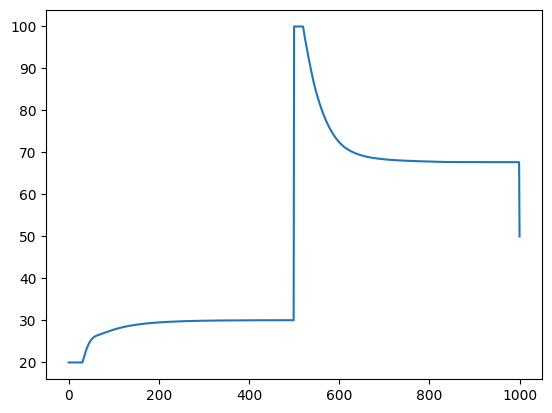

In [246]:
u_noC = scalerU.inverse_transform(u.T)
plt.plot(u_noC)
#0 90 ok
#1 51 bad
#2 50 bad
#3 60 meh
#4 80 not usable
#5 100 okish
#6 55 bad
#7 54 bad
#8 60 nah
#9 90 okish

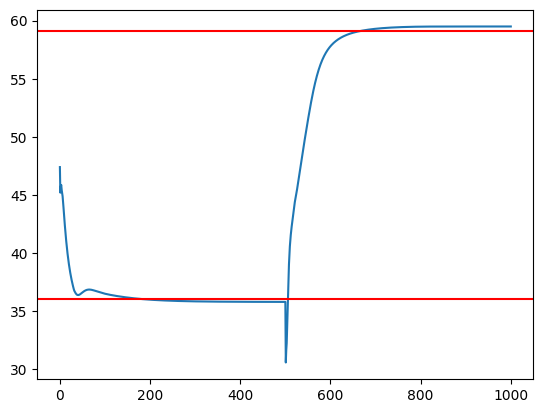

In [247]:
#y = get_vector_y_noC(x)

y_noC = scaler.inverse_transform(y.T)
plt.plot(y_noC)
plt.axhline(y = scaler.inverse_transform(get_y_noC(x_ref)), color = 'r', linestyle = '-') 
plt.axhline(y = scaler.inverse_transform(get_y_noC(x_store)), color = 'r', linestyle = '-') 

In [248]:
print("end", y_noC[-2])
print("Reference", scaler.inverse_transform(get_y_noC(x_ref)))

end [59.48982944]
Reference [[59.10674]]


In [249]:
scaler.inverse_transform(get_y_noC(x_ref))

array([[59.10674]], dtype=float32)

In [250]:
sum300 = sum(sum((y_noC[:300]-scaler.inverse_transform(get_y_noC(x_store)))**2))
sum600 = sum(sum((y_noC[300:]-scaler.inverse_transform(get_y_noC(x_store2)))**2))
print(sum300+sum600)

123211.89191438841


# optimal Q?

In [251]:
# import cvxpy as cp
# import numpy as np

# # Define the diagonal matrix variable
# n = 10  # Assuming 5 dimensions, adjust as needed
# Q_diag = cp.Variable(n, nonneg=True)  # Elements of Q must be positive

# # Define the complicated function that depends on Q


# # Define the optimization problem
# objective = cp.Minimize(metric(Q_diag))  # Or cp.Maximize() depending on your goal
# constraints = []  # Add any other constraints if necessary

# problem = cp.Problem(objective, constraints)

# # Solve the optimization problem
# problem.solve()

# # The optimal diagonal elements of Q
# optimal_Q_diag = Q_diag.value


In [252]:
y_noC[:300].shape

(300, 1)

In [253]:
sum300 = sum(sum((y_noC[:300]-scaler.inverse_transform(get_y_noC(x_store)))**2))
sum600 = sum(sum((y_noC[300:]-scaler.inverse_transform(get_y_noC(x_store2)))**2))
print(sum300+sum600)

123211.89191438841


In [254]:
scaler.inverse_transform(get_y_noC(x_store))

array([[36.040806]], dtype=float32)

In [255]:
# from deap import base, creator, tools, algorithms
# import random
# from multiprocessing import Pool



# sim_len = 640

# def complicated_function(Q_diag):
#     Qx = np.diag(np.abs(Q_diag))  # Construct Q as a diagonal matrix
#     x = np.zeros((nx_koopman, sim_len+1))
#     x_basline = np.zeros((nx_koopman_baseline, sim_len+1))
#     u = np.zeros((nu, sim_len+1))
#     y = np.zeros((ny, sim_len+1))

#     init_cond = scaler.transform(np.array([[47.40084585]]))
#     x0 = get_x_noC(init_cond)
#     x_ref = np.array([x_store]).T
#     u_first = scalerU.transform(np.array([[20]]))
#     u_prev = u_first


#     x[:,0] = x0[:,0]
#     y[:,0] = init_cond.flatten()


#     x0_baseline = get_x_baseline(init_cond)
#     x_basline[:,0] = x0_baseline.flatten()
    
#     for i in range(sim_len):
#         if i == 200:
#             x_ref = np.array([x_store2]).T
#         Q = dense.quad_form_cr(A_noC, B_noC, Qx, Qu, N)
#         c = dense.lin_form_cr(A_noC, B_noC, Qx, Qu, N, x0, x_ref, u_prev)
#         F = dense.constraint_matrix_sr_nox(N)
#         g = dense.upper_bound_sr_nox(N,umax, umin)
        
#         U = cp.Variable((N, nu))
        
#         objective = cp.Minimize(cp.quad_form(U, Q) + c @ U)
#         constraints = [F @ U <= g]
        
#         problem_mpc = cp.Problem(objective, constraints)
#         problem_mpc.solve()
        
#         #print(U.value)
#         u[:, i] = U.value[0, :].reshape(-1, 1) #scalerU.transform(np.array([[75]]))#U.value[0, :].reshape(-1, 1)
        
#         y[:,i+1], x_basline[:,i+1] = y_plus_baseline(x_basline[:,i], u[:, i])
            
#         x0 = get_x_noC(y[:,i+1])[:,0] #x[:, i+1] #- x_in_0[:,0] 
#         x[:,i] = x0
#         #get_x(y[:,i])[:,0]
#         u_prev = u[:,i]
#     y_noC = scaler.inverse_transform(y.T)
#     u_noC = scalerU.inverse_transform(u.T)
#     return y_noC, u_noC

# # Define the metric (as an objective function to minimize or maximize)
# def metric(Q_diag):
#     output, u_output = complicated_function(Q_diag)
#     sum300 = sum(sum(np.abs(output[:200]-scaler.inverse_transform(get_y_noC(x_store)))))
#     sum600 = sum(sum(np.abs(output[200:]-scaler.inverse_transform(get_y_noC(x_store2)))))
#     bounds_counter = 0
#     for i in range(len(u_output)):
#         if u_output[i] == 20:
#             bounds_counter += 1
#         elif u_output[i] == 100:
#             bounds_counter += 1
#         else:
#             pass
#     print(bounds_counter)
#     print(sum300+sum600)
#     return sum300+sum600-bounds_counter*5  # Your custom metric

# # Define the fitness function
# def fitness(individual):
#     Q_diag = individual
#     return metric(Q_diag),  # Return as a tuple (since DEAP expects this)

# # Set up DEAP for a continuous optimization problem
# creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize the metric
# creator.create("Individual", list, fitness=creator.FitnessMin)

# toolbox = base.Toolbox()
# toolbox.register("attr_float", random.uniform, 0.5, 100.0)  # Random positive float values
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=10)  # n is the size of the diagonal
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# toolbox.register("mate", tools.cxBlend, alpha=0.5)
# toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.1, indpb=0.2)
# toolbox.register("select", tools.selTournament, tournsize=3)
# toolbox.register("evaluate", fitness)
# #toolbox.register("map", Pool().map)

# # Create a population of individuals (possible solutions)
# population = toolbox.population(n=20)

# # Run the genetic algorithm
# algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=20, verbose=True)

# # Extract the best solution
# best_individual = tools.selBest(population, 1)[0]
# optimal_Q_diag = best_individual


In [256]:
print(optimal_Q_diag)
#2074 10 10
#1301 20 20
#17709 20 20 [80.35211663828885, 7.988431927554915, -1.05198264273972, 127.23237721218146, 1.5552219905539335, 0.0033002193149051754, 0.87461281157358, 77.16858246720281, 29.7903391391592, 12.282372835760407]
#14992 50 50 [0.20149353830922156, 0.007919624374623284, -0.22275652346578914, 947.6451185928719, -0.015637595036868082, -0.0008411937883357375, -0.06206500021055139, -0.08573367348178118, 0.1636606106713353, -0.004094849589637423]

# new vith abs no control on limits
# 1522 20 20 [87.77470039047095, 2.841340274383008, 19.09892148057286, 87.22664263772776, 17.523706253843294, 5.206652070704854, 0.26459432612850287, 101.24763875834651, -2.8485785665645738, -2.203979345956818]

# control on limits
#

NameError: name 'optimal_Q_diag' is not defined

In [58]:
scaler.inverse_transform(np.array([[0]]))

array([[46.99871319]])

## wC

In [257]:
Qy = np.eye(ny)*0.01
Qu = np.eye(nu)*0.1


umax = scalerU.transform(np.array([[100]]))
umin = scalerU.transform(np.array([[20]]))

x = np.zeros((nx_koopman, sim_len+1))
x_basline = np.zeros((nx_koopman_baseline, sim_len+1))
u = np.zeros((nu, sim_len+1))
y = np.zeros((ny, sim_len+1))

x0 = get_x(init_cond)
y_ref = get_y_noC(np.array([x_store]).T)#get_y_noC(x_ref)#scaler.transform(np.array([[55]]))
 
u_prev = u_first


x[:,0] = x0[:,0]
y[:,0] = init_cond.flatten()


x0_baseline = get_x_baseline(init_cond)
x_basline[:,0] = x0_baseline.flatten()



In [258]:
start = tim.time()
for i in range(sim_len):
    if i == 500:
        y_ref = get_y_noC(np.array([x_store2]).T)
        
    Q = dense.quad_form(A_wC, B_wC, C_wC, D_wC, Qy, Qu, N)                      
    c = dense.lin_form(A_wC, B_wC, C_wC, D_wC, Qy, Qu, N, x0, y_ref, u_prev)  
      
    F = dense.constraint_matrix_no(B_wC, N)                   
    g = dense.upper_bound_no(umax, umin, N)
    
    U = cp.Variable((N, nu))
    
    objective = cp.Minimize(cp.quad_form(U, Q) + c @ U)
    constraints = [F @ U <= g]
    
    problem_mpc = cp.Problem(objective, constraints)
    problem_mpc.solve()
    
    u[:, i] = U.value[0, :].reshape(-1, 1)
    
    # propagation in time
    y[:,i+1], x_basline[:,i+1] = y_plus_baseline(x_basline[:,i], u[:, i])
    noise = np.random.normal(noise_mean, noise_std)
    y[:,i+1] = y[:,i+1] #+ noise
    
    x0 = get_x(y[:, i+1].reshape(1,-1))
    u_prev = u[:,i]
    print(i)
end = tim.time()
print(f"Elapsed time MPC: {end-start:.2f} sec")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [259]:
Q = dense.quad_form(A_wC, B_wC, C_wC, D_wC, Qy, Qu, N) 

In [260]:
Gamma_y = dense.create_Gamma_y(A_wC, B_wC, C_wC, D_wC, N)
Lambda = dense.create_Lambda(B_wC.shape[1], N)
Wy = dense.create_weighting(Qy, N)
Wu = dense.create_weighting(Qu, N)

In [261]:
Gamma_y[2,:]

array([0.05285027, 0.05067204, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

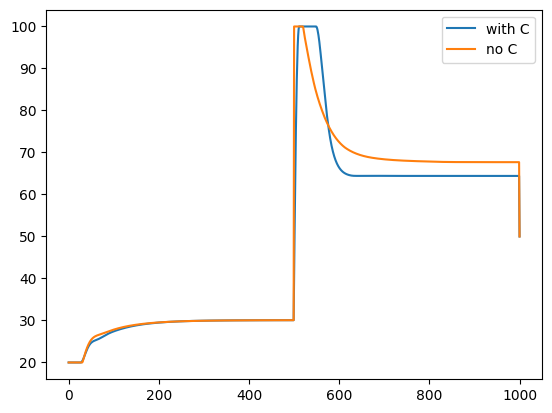

In [262]:
u_wC = scalerU.inverse_transform(u.T)
plt.plot(u_wC, label = "with C")
plt.plot(u_noC, label = "no C")
plt.legend() 

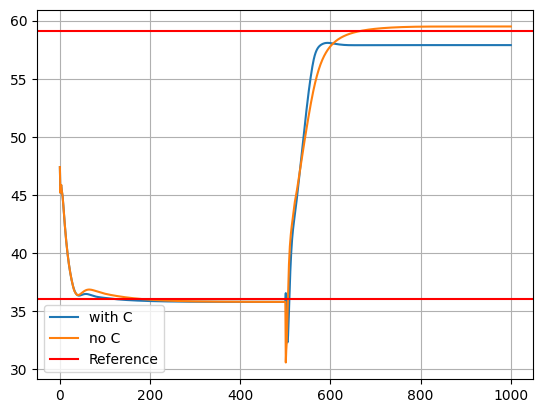

In [263]:
y_wC = scaler.inverse_transform(y)
plt.plot(y_wC.T, label = 'with C')
plt.plot(y_noC, label = 'no C')
plt.axhline(y = scaler.inverse_transform(get_y_noC(x_store2)), color = 'r', linestyle = '-',label = "Reference")
plt.axhline(y = scaler.inverse_transform(get_y_noC(x_store)), color = 'r', linestyle = '-') 
plt.grid()
plt.legend() 

In [264]:
#comparison y

mse_noC = np.mean((y_noC - scaler.inverse_transform(get_y_noC(x_ref)))**2)
mse_wC = np.mean((y_wC.T - scaler.inverse_transform(get_y_noC(x_ref)))**2)
print("MSE no C", mse_noC)
print("MSE w C", mse_wC)

# total absolute error
ae_noC = np.sum(np.abs(y_noC - scaler.inverse_transform(get_y_noC(x_ref))))
ae_wC = np.sum(np.abs(y_wC.T - scaler.inverse_transform(get_y_noC(x_ref))))
print("AE no C", ae_noC)
print("AE w C", ae_wC)
print("AE better", ae_noC/ae_wC)

MSE no C 272.89867608813375
MSE w C 276.1722438775078
AE no C 12445.550888079644
AE w C 12775.524936050782
AE better 0.9741713902463611


In [67]:
#comparison u

print("sum u no C", sum(u_noC)) 
print("sum u w C", sum(u_wC))

print("noC better than wC", sum(u_noC)/sum(u_wC))

sum u no C [49556.10115514]
sum u w C [48805.89902572]
noC better than wC [1.01537114]


In [68]:
# the_dif = []
# for j in range(25,63):
#     u = np.zeros((nu, 300+1))
#     y = np.zeros((ny, 300+1))   
#     start = tim.time()
#     for i in range(300):
#         y_ref = scaler.transform(np.array([[j]]))
            
#         Q = dense.quad_form(A_wC, B_wC, C_wC, D_wC, Qy, Qu, N)                      
#         c = dense.lin_form(A_wC, B_wC, C_wC, D_wC, Qy, Qu, N, x0, y_ref, u_prev)  
        
#         F = dense.constraint_matrix_no(B_wC, N)                   
#         g = dense.upper_bound_no(umax, umin, N)
        
#         U = cp.Variable((N, nu))
        
#         objective = cp.Minimize(cp.quad_form(U, Q) + c @ U)
#         constraints = [F @ U <= g]
        
#         problem_mpc = cp.Problem(objective, constraints)
#         problem_mpc.solve()
        
#         u[:, i] = U.value[0, :].reshape(-1, 1)
        
#         # propagation in time
#         y[:,i+1], x_basline[:,i+1] = y_plus_baseline(x_basline[:,i], u[:, i])
#         noise = np.random.normal(noise_mean, noise_std)
#         y[:,i+1] = y[:,i+1] #+ noise
        
#         x0 = get_x(y[:, i+1].reshape(1,-1))
#         u_prev = u[:,i]
#     end = tim.time()
#     the_dif.append((y[:,-1]-y_ref)[0][0])

#     print(the_dif)
#     print(f"Elapsed time MPC: {end-start:.2f} sec")
#     print(j)

In [69]:
np.argmax(the_dif[5:20])+25+5

NameError: name 'the_dif' is not defined

## data matrices Q?
doesnt work


In [70]:
y = train_sim["Y"]
Qy = np.eye(ny)
Qx = Qx

In [71]:
x.shape

(10, 1001)

In [72]:
J_wC = 0
for i in range(len(y)):
    J_wC += y[i].T@Qy@y[i]
J_wC

8224936.92004712

In [73]:
Qx = np.zeros((nx_koopman,nx_koopman))
for i in range(nx_koopman):
    if dominant_indices[i] <= 1:
        Qx[i,i] = 2
    else:
        Qx[i,i] = 0.340373

In [74]:
J_noC = 0
for i in range(len(y)):
    J_noC += get_x_noC(y[0].reshape(1,-1)).T@Qx@get_x_noC(y[0].reshape(1,-1))
J_noC-J_wC

array([[0.83504898]])

In [75]:
A_noC

array([[ 0.03314717, -0.25581697,  0.09998726, -0.23271932,  0.12665087,
        -0.17073508,  0.21180293, -0.2471502 ,  0.07163967,  0.00122904],
       [ 0.08355362, -0.16044956, -0.15423574,  0.23772718, -0.01605194,
        -0.12439167,  0.16930173,  0.18604624,  0.20297623,  0.11553277],
       [ 0.12892571, -0.27997026,  0.28883326, -0.2384694 , -0.17741352,
        -0.05230264, -0.17205212, -0.17049746, -0.2552227 , -0.08708481],
       [-0.09859434,  0.24986893, -0.29638925,  0.3042613 , -0.01979108,
        -0.00577741,  0.24686103,  0.19743828, -0.13328114,  0.30765098],
       [ 0.14929453, -0.01860546,  0.04965121,  0.16837078,  0.5486045 ,
        -0.14622681, -0.33855554,  0.02806116,  0.06037605, -0.35823235],
       [-0.25404087,  0.25508156, -0.39349088,  0.2031294 ,  0.2164964 ,
        -0.01000398, -0.13952063, -0.10453252,  0.34339792,  0.2257788 ],
       [-0.32743657, -0.2726294 ,  0.04147049, -0.16060697, -0.18451974,
        -0.04765293,  0.23609236, -0.18177076

In [76]:
B_noC

array([[ 0.6135751 ],
       [ 0.74707556],
       [-0.06414523],
       [-0.2748463 ],
       [ 0.1424983 ],
       [ 0.5087134 ],
       [ 0.43084744],
       [-0.50726736],
       [ 0.0396772 ],
       [ 0.28033966]], dtype=float32)

# Unscented Kalman Filter

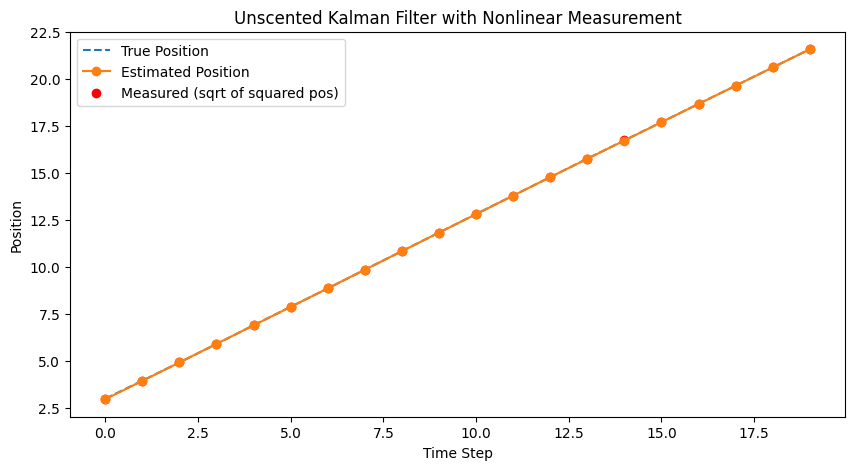

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# Define the state transition function (Linear)
def f_cv(state, dt):
    """State transition function for a constant velocity model."""
    x, v = state  # State: [position, velocity]
    x_new = x + v * dt
    return np.array([x_new, v])

# Define the measurement function (Nonlinear)
def h_nonlinear(state):
    """Nonlinear measurement function (e.g., measuring squared position)."""
    x, v = state
    return np.array([x**2])  # We measure squared position instead of direct x

# Define UKF parameters
dt = 1.0  # Time step
dim_x = 2  # Number of states [position, velocity]
dim_z = 1  # Number of measurements (nonlinear function of position)

# Create sigma points generator
sigmas = MerweScaledSigmaPoints(n=dim_x, alpha=0.1, beta=2.0, kappa=0)

# Initialize UKF
ukf = UKF(dim_x=dim_x, dim_z=dim_z, fx=f_cv, hx=h_nonlinear, dt=dt, points=sigmas)

# Set initial state and covariance
ukf.x = np.array([2.0, 1.0])  # Initial state: [position=2, velocity=1]
ukf.P = np.eye(dim_x) * 0.1  # Initial uncertainty

# Process and measurement noise
ukf.Q = np.eye(dim_x) * 0.01  # Process noise
ukf.R = np.eye(dim_z) * 0.1   # Measurement noise

# Simulate measurements
np.random.seed(42)
num_steps = 20
true_states = []
measurements = []
estimated_states = []

for k in range(num_steps):
    # Simulate true state
    true_state = f_cv(ukf.x, dt)
    true_states.append(true_state)
    
    # Simulate nonlinear measurement with noise
    measurement = h_nonlinear(true_state) + np.random.normal(0, 0.1)
    measurements.append(measurement)
    
    # UKF update step
    ukf.predict()
    ukf.update(measurement)
    
    # Store estimates
    estimated_states.append(ukf.x.copy())

# Convert lists to arrays for plotting
true_states = np.array(true_states)
measurements = np.array(measurements)
estimated_states = np.array(estimated_states)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(true_states[:, 0], label="True Position", linestyle="dashed")
plt.plot(estimated_states[:, 0], label="Estimated Position", marker="o")
plt.scatter(range(num_steps), np.sqrt(measurements), label="Measured (sqrt of squared pos)", color="red")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.legend()
plt.title("Unscented Kalman Filter with Nonlinear Measurement")
plt.show()


In [95]:
get_x_noC(y[0].reshape(1,-1))[:,0].shape

(10,)

array([-0.63171288, -0.5858636 ,  0.23948109,  0.11337433,  0.09135618,
       -0.62725328, -0.29726114,  0.63454716, -0.14003874,  0.01683729])

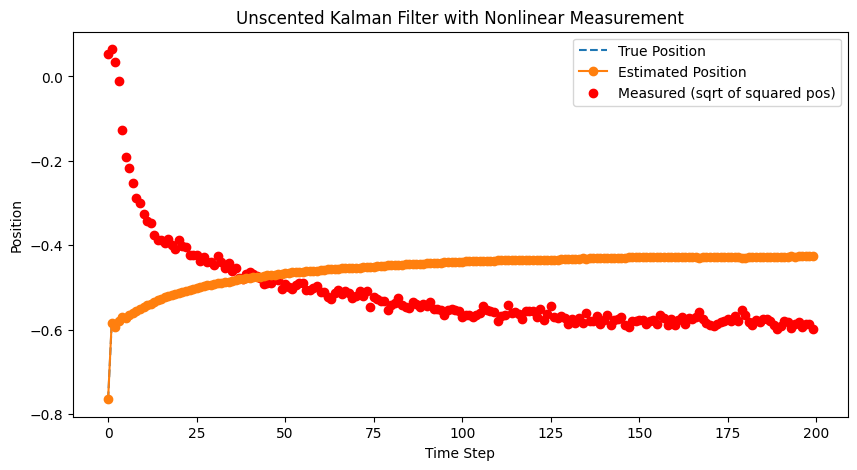

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# Define the state transition function (Linear)
def f_cv(state, u):
    x = state.reshape(-1,1)
    x_new = A_noC@x + B_noC*u
    return x_new.flatten()

# Define the measurement function (Nonlinear)
def h_nonlinear(state):
    y = get_y_noC(state)
    return y.flatten()

# Define UKF parameters
dt = 1.0  # Time step
dim_x = 10  # Number of states [position, velocity]
dim_z = 1  # Number of measurements (nonlinear function of position)

# Create sigma points generator
sigmas = MerweScaledSigmaPoints(n=dim_x, alpha=0.1, beta=2.0, kappa=0)

# Initialize UKF
ukf = UKF(dim_x=dim_x, dim_z=dim_z, fx=f_cv, hx=h_nonlinear, dt=dt, points=sigmas)

# Set initial state and covariance
ukf.x = get_x_noC(np.array([0])).flatten()  # Initial state: [position=2, velocity=1]
ukf.P = np.eye(dim_x) * 0.1  # Initial uncertainty

# Process and measurement noise
ukf.Q = np.eye(dim_x) * 0.01  # Process noise
ukf.R = np.eye(dim_z) * 0.1   # Measurement noise

# Simulate measurements
np.random.seed(42)
num_steps = 200
true_states = []
measurements = []
estimated_states = []

for k in range(num_steps):
    u_k = np.array([-1])
    # Simulate true state
    true_state = f_cv(ukf.x, u_k)
    true_states.append(true_state)
    
    # Simulate nonlinear measurement with noise
    measurement = h_nonlinear(true_state) + np.random.normal(0, 0.01)
    measurements.append(measurement)
    
    # UKF update step
    ukf.predict(dt=u_k)

    ukf.update(measurement)
    # Store estimates
    estimated_states.append(ukf.x.copy())

# Convert lists to arrays for plotting
true_states = np.array(true_states)
measurements = np.array(measurements)
estimated_states = np.array(estimated_states)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(true_states[:, 1], label="True Position", linestyle="dashed")
plt.plot(estimated_states[:, 1], label="Estimated Position", marker="o")
plt.scatter(range(num_steps), measurements, label="Measured (sqrt of squared pos)", color="red")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.legend()
plt.title("Unscented Kalman Filter with Nonlinear Measurement")
plt.show()


In [133]:
true_state

array([-0.63171288, -0.5858636 ,  0.23948109,  0.11337433,  0.09135618,
       -0.62725328, -0.29726114,  0.63454716, -0.14003874,  0.01683729])